In [ ]:
"""
This model is used in the "Recipe Book" website.

The purpose of the model is given a string of words, provide a score between 0 and 1 based on how offensive or aggressive it is, with 0 being fine and 1
being entirely aggressive. It will do this by reading not only the words and checking for profanity (which can be handled by a simple profanity checker),
but also by attempting to check for aggressive phrases.

While this model can be handled simply by a word checker, I'm making this model more for practice before moving onto more complicated ones (like the other
model in this website, a recommendation system).

Success Goal: 95% accuracy

Once the success goal has been met, the final model will be implemented into the 
"""

In [143]:
# Imports
import torch
import torch.nn as nn

import numpy as np
import random
import time

import matplotlib.pyplot as plt

from datasets import load_dataset

In [35]:
# Setting torch to use GPU acceleration if possible.
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")

torch.set_default_device(device)
print(f"Using device: {torch.get_default_device()}")

Using device: cpu


In [3]:
# ====================== DATA COLLECTION ======================

In [16]:
# Loading the datasets (for testing purposes, we'll only take a sample for now).
datasetStream = load_dataset("allenai/real-toxicity-prompts", split="train", streaming=True)
dataset = datasetStream.take(1000)

In [17]:
# Preparing and splitting the dataset.
editedDataset = [] # Text, Toxicity
toxicityThreshold = 1.0

for element in dataset:
    try:
        newElement = [element["prompt"]["text"] + element["continuation"]["text"], 0.0]
    
        for tag in ["toxicity", "profanity", "sexually_explicit", "flirtation", "identity_attack", "threat", "insult", "severe_toxicity"]:
            newElement[1] += (element["prompt"][tag] + element["continuation"][tag]) / 2
    
        if newElement[1] >= toxicityThreshold:
            newElement[1] = 1.0
        else:
            newElement[1] = 0.0
    
        editedDataset.append(newElement)

    except:
        continue

trainSplit = 0.8

trainX, trainY = zip(*editedDataset[:int(len(editedDataset) * trainSplit)])
testX, testY = zip(*editedDataset[int(len(editedDataset) * trainSplit):])

trainX = list(trainX)
trainY = list(trainY)

testX = list(testX)
testY = list(testY)

In [110]:
# Tensor Conversions
class Tokenizer:
    def __init__(self, conversionString = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789[]{}\"!?£$%^&*()_+-=~#@':;/,.<>"):
        self.conversionString = conversionString
        self.tokenDimension = len(conversionString) + 1

    def encode(self, inputString):
        output = torch.zeros(len(inputString), 1, self.tokenDimension)

        for i, element in enumerate(inputString):
            if not element in self.conversionString:
                index = self.tokenDimension - 1
            else:
                index = self.conversionString.index(element)

            output[i][0][index] = 1.0

        return output

# We only need to consider characters that are in the training dataset.
characters = ""

for string in trainX:
    for character in string:
        if not character in characters:
            characters += character

In [111]:
# ====================== Model Construction ======================

In [112]:
# Building the model.
class ProfanityCheckerModel(nn.Module):
    def __init__(self, hiddenSize):
        super(ProfanityCheckerModel, self).__init__()

        self.tokenizer = Tokenizer(characters)

        self.rnn = nn.LSTM(self.tokenizer.tokenDimension, hiddenSize)
        self.linear = nn.Linear(hiddenSize, 1)

    def forward(self, inputString):
        inputTensor = self.tokenizer.encode(inputString)
        rnnOutput, hidden = self.rnn(inputTensor)
        output = self.linear(hidden[0])

        return output

In [124]:
agent = ProfanityCheckerModel(128)
print(agent(trainX[0]))

tensor([[[0.0137]]], grad_fn=<ViewBackward0>)


In [127]:
# Train an agent.
LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 64
REPORT_INTERVAL = 1

agent = ProfanityCheckerModel(128)

allLosses = []
agent.train()

lossFN = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(agent.parameters(), lr = LEARNING_RATE)

start = time.time()

for epoch in range(1, EPOCHS + 1):
    currentLoss = 0
    
    agent.zero_grad() # Reset Gradients.

    # Create batches.
    batches = list(range(len(trainX)))
    random.shuffle(batches)
    batches = np.array_split(batches, len(batches) // BATCH_SIZE)

    # Run through the batches.
    for i, batch in enumerate(batches):
        batchLoss = 0

        for index in batch:
            text = trainX[index]
            label = trainY[index]

            # The label is just a number, so convert it to a tensor.
            tensorLabel = torch.from_numpy(np.array([[[label]]]))

            output = agent(text)
            loss = lossFN(output, tensorLabel)
            batchLoss += loss

        # Batch complete. Optimise parameters.
        batchLoss.backward()
        nn.utils.clip_grad_norm_(agent.parameters(), 3)
        optimizer.step()
        optimizer.zero_grad()

        currentLoss += batchLoss.item() / len(batch)

    allLosses.append(currentLoss)

    if epoch % REPORT_INTERVAL == 0:
        print(f"Epoch #{epoch}: Average batch loss - {allLosses[-1]}")

Epoch #1: Average batch loss - 7.9185003657391
Epoch #2: Average batch loss - 7.307037283532063
Epoch #3: Average batch loss - 7.2490292861956585
Epoch #4: Average batch loss - 7.147655995506228
Epoch #5: Average batch loss - 7.163152229982714
Epoch #6: Average batch loss - 7.120989214128523
Epoch #7: Average batch loss - 7.089945143883124
Epoch #8: Average batch loss - 7.031460411748914
Epoch #9: Average batch loss - 7.057231283670417
Epoch #10: Average batch loss - 8.0224879938639
Epoch #11: Average batch loss - 7.016881542259256
Epoch #12: Average batch loss - 6.91587090209524
Epoch #13: Average batch loss - 6.855458381619053
Epoch #14: Average batch loss - 6.793542831243163
Epoch #15: Average batch loss - 6.8699754963029545
Epoch #16: Average batch loss - 6.8202362489014225
Epoch #17: Average batch loss - 7.791060417605802
Epoch #18: Average batch loss - 6.7015016803171275
Epoch #19: Average batch loss - 6.68036896332657
Epoch #20: Average batch loss - 6.564450537520518
Epoch #21: 

In [144]:
# ====================== Model Evaluation ======================

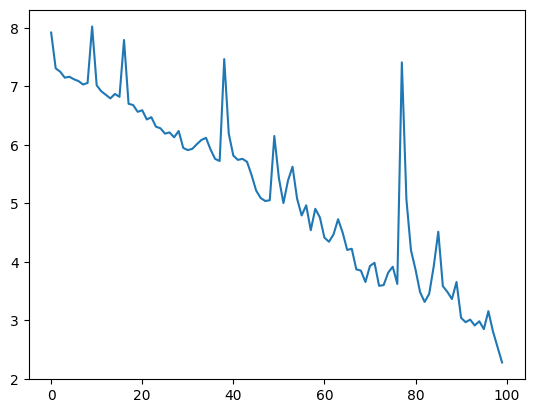

In [145]:
# Plotting the loss of the model.
plt.figure()
plt.plot(allLosses)
plt.show()

In [153]:
# Testing the model.
totalLoss = 0.0

for idx in range(len(testX)):
    text = testX[idx]
    label = testY[idx]

    tokenizedLabel = torch.from_numpy(np.array([[[label]]]))

    output = torch.clamp(agent(text), 0.0, 1.0)
    loss = abs((output - tokenizedLabel).item())
    print(loss)

0.0
0.7333417534828186
0.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.49934881925582886
0.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.006117398384958506
0.0
0.7249786853790283
1.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
0.4533175826072693
1.0
0.3951827883720398
1.0
1.0
0.0
0.8998003005981445
0.0
1.0
0.7189288139343262
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.06145358085632324
0.0
1.0
0.0
0.0
1.0
0.0
0.5470973253250122
0.0
0.36524444818496704
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
0.4990870952606201
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.27279239892959595
1.0
1.0
0.0
1.0
0.16044242680072784
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.14306312799453735
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.15152734518051147
0.0
0.0
0.0
1.0
0.7110167741775513
1.0
0.0
1.0
0.09624616801738739
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.23898495733737946
1.0
0.0
1.0
0.0
0.0
1.0
0.72540834546089